# Predicting Optimal 4th-Down Play Calls in NFL Games
College of Charleston, Department of Computer Science \
Final Project - Data Mining (CSCI 334)

Connor Cozad and Maddie Carrino \
March and April 2022

## Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)  # Display all columns in DataFrames
pd.set_option('display.max_colwidth', None)

In [3]:
plt.rcParams['axes.spines.right'] = False   # Remove top and right borders on plots
plt.rcParams['axes.spines.top'] = False
plt.rcParams['figure.dpi'] = 300

In [4]:
import warnings
warnings.filterwarnings("ignore")  # Supresses some deprication warnings raised in the code below

Our web scraping notebook produced a CSV file containing the plays from every NFL game in a single year. We have CSVs containing these plays from 2003 through 2021. Here, we read in these CSV files and merge them into a single DataFrame.

In [5]:
plays = pd.read_csv('Play by Play CSVs/2003.csv')
for year in range(2004, 2022):
    plays = pd.concat([plays, pd.read_csv(f'Play by Play CSVs/{year}.csv')])
plays = plays.reset_index(drop=True)
plays.head(1)

Game ID  Postseason Home Team  Home Team Score Away Team  \
0  230928013       False       OAK                0        SD   

   Away Team Score Quarter  Clock Possession      Down Ball Placement  \
0                0       1  14:55        OAK  1st & 10          LV 32   

                                          Description  
0  Charlie Garner (OAK) rushed left side for 2 yards.

## Data Preprocessing

### Separate `Yards To Go` and `Down` Columns

The `Down` column currently contains values like "2nd and 4". We want to split this into two columns, where "2nd" is in the `Down` column and "4" is in the `Yards to Go` column.

In [6]:
plays[['Down', 'Yards to Go']] = plays['Down'].str.split(' & ', expand=True) # Split columns on " & "

In [7]:
plays[['Down', 'Yards to Go']].head(1)

Down Yards to Go
0  1st          10

### Drop Rows with Missing Value in `Description` Column

The description column is vital in determining the type of play (punt, field goal, or "go for it"). Only about 5% of all plays have a missing description, so we drop them from the dataset.

In [8]:
len(plays[plays['Description'].isna()]) / len(plays)  # percent of plays missing a description

0.05186309987670267

In [9]:
plays = plays.dropna(subset='Description')

In [10]:
len(plays[plays['Description'].isna()])  # missing values remaining in the Description column

0

### Identify 4th Down Plays as Successful/Unsuccessful

We only want to train our model on <i>successful</i> 4th down plays. If we showed the model unsuccessful plays, it would learn what <i>not</i> to do on 4th down. A 4th down play is successful if:
- The team attempts a field goal, and a 3-point increase in their score is reflected in the next play.
- The team kicks a punt (all punts are considered successful)
- The team attempts to "go for it", and they succeed, meaning they still have possession of the ball on the next play, or a 6-, 7-, or 8-point increase in their score is reflected in the next play (meaning a touchdown was scored).

In [11]:
# Calculate the number of points scored on each play
plays['Home Team Score Change'] = plays['Home Team Score'].shift(-1) - plays['Home Team Score']
plays['Away Team Score Change'] = plays['Away Team Score'].shift(-1) - plays['Away Team Score']

# Ignore the last row in each game, which doesn't represent an actual play, just the final score of the game
plays.loc[plays['Description'] == 'Final', 'Home Team Score Change'] = np.nan
plays.loc[plays['Description'] == 'Final', 'Away Team Score Change'] = np.nan

In [12]:
# Determine the type of play for each play
def evaluate_play_type(x):
    try:
        if 'field goal' in x.lower():
            return 'Field Goal'
        elif 'punt' in x.lower():
            return 'Punt'
        else: # Going for it include touchdowns
            return 'Go For It'
    except:
        print(x, type(x))

plays['Play Type'] = plays['Description'].apply(evaluate_play_type)

In [13]:
# Determine whether the possession changes following each play
plays['Possession Change After Play'] = plays['Possession'].shift(-1) != plays['Possession']

# Ignore the last row in each game, which doesn't represent an actual play, just the final score of the game
plays.loc[plays['Description'] == 'Final', 'Possession Change After Play'] = np.nan

In [14]:
# Determine whether the play was successful
def evaluate_play_success(row):
    if row['Play Type'] == 'Field Goal':
        # Returns True if field goal was successful (3 points scored)
        return row['Home Team Score Change'] == 3 or row['Away Team Score Change'] == 3
    elif row['Play Type'] == 'Punt':
        return True
    else: # Play type is "Go For It"
        # Returns True if touchdown was successful (6, 7, or 8 points scored) or possession did not change after the play
        return row['Home Team Score Change'] in [6, 7, 8] or row['Away Team Score Change'] in [6, 7, 8] or not row['Possession Change After Play']

plays['Play Success'] = plays.apply(evaluate_play_success, axis=1)

### Filter Down to Successful 4th Down Plays

As stated before, we only want to train our model on successful 4th down plays, so we filter down our data to only 4th down plays that were also successful.

In [15]:
plays = plays[(plays['Down'] == '4th') & (plays['Play Success'] == True)]
plays = plays.reset_index(drop=True)
plays.tail(1)

Game ID  Postseason Home Team  Home Team Score Away Team  \
68670  401326411       False       BAL               34       LAC   

       Away Team Score Quarter Clock Possession Down Ball Placement  \
68670                6       4  5:28        LAC  4th         BAL 37   

                                                        Description  \
68670  J.Herbert up the middle to BLT 35 for 2 yards (J.Madubuike).   

      Yards to Go  Home Team Score Change  Away Team Score Change  Play Type  \
68670           1                     0.0                     0.0  Go For It   

      Possession Change After Play  Play Success  
68670                        False          True

### Feature Extraction

In this section, we create 7 variables that are useful in predicting 4th down plays.

If home team advantage has any effect on 4th down play decisions, we create this boolean feature:

- Possession Team is at Home

Currently, the scores are in terms of home team and away team. However, in predicting 4th down plays, we want to know the scores in terms of the team in possession and not in possession of the ball. Therefore, we create these variables:

- Possession Team Score Relative to Non-Possession Team
- Possession Team's Score
- Non-Possession Team's Score

Currently, time remaining in the game depends on the game clock, and quarter. We combine this into one variable, which tells the number of minutes remaining in the game as a whole, which is a better predictor than the number of minutes remaining in the quarter (which is given by the game clock):

- Minutes to Game End

Yards to reach first down and yards to the end zone are important factors in the 4th down decision process, and had to be calculated from the ball's placement on the field:

- Yards to First Down
- Yards to End Zone

#### Possession Team is at Home

In [16]:
plays['Possession Team is Home'] = (plays['Home Team'] == plays['Possession'])

#### Possession Team Score Relative to Non-Possession Team

In [17]:
def possession_team_up_by(row):
    if row['Possession'] == row['Home Team']:
        return row['Home Team Score'] - row['Away Team Score']
    else: # Away team has possession
        return row['Away Team Score'] - row['Home Team Score']

plays['Possession Team Up By'] = plays.apply(possession_team_up_by, axis=1)

#### Possession Team's Score

In [18]:
def possession_team_score(row):
    if row['Possession'] == row['Home Team']:
        return row['Home Team Score']
    else: # Away team has possession
        return row['Away Team Score']

plays['Possession Team Score'] = plays.apply(possession_team_score, axis=1)

#### Non-Possession Team's Score

In [19]:
def non_possession_team_score(row):
    if row['Possession'] == row['Home Team']:
        return row['Away Team Score']
    else: # Away team has possession
        return row['Home Team Score']

plays['Non-Possession Team Score'] = plays.apply(non_possession_team_score, axis=1)

#### Minutes to End of Game

In [20]:
def mins_to_end(row):
    minutes, seconds = row['Clock'].split(':')
    quarter = row['Quarter']
    mins_left_in_quarter = float(minutes) + (float(seconds) / 60)
    if quarter in ['1', '2', '3', '4']:
        return mins_left_in_quarter + (4 - int(quarter)) * 15.0
    else: # Overtime
        return mins_left_in_quarter

plays['Minutes to End Game'] = plays.apply(mins_to_end, axis=1)

#### Yards to First Down

In [21]:
def yards_to_first_down(row):
    if row['Yards to Go'] == 'Goal':
        return int(row['Ball Placement'].split()[-1])
    else:
        return int(row['Yards to Go'])

plays['Yards to First Down'] = plays.apply(yards_to_first_down, axis=1)

#### Yards to End Zone

In [22]:
def yards_to_end_zone(row):
    if row['Ball Placement'] == '50':
        territory, yard_line = ' ', '50'
    else:
        territory, yard_line = row['Ball Placement'].split()
    
    yard_line = int(yard_line)

    ball_on_opposite_side_of_field = row['Possession'] == territory # Ball in the territory of the team in possession
    if ball_on_opposite_side_of_field: # Ball in the territory of the team in possession
        return 100 - yard_line
    else: # Ball in the territory of the team not in possession
        return yard_line

plays['Yards to End Zone'] = plays.apply(yards_to_end_zone, axis=1)

### Drop Rows with Erroneous Data (Outliers)
Some values calculated for the newly-create features are non-sensical. A team's score should never decrease between one play and the next. And the number of yards to reach 1st down should never be negative. Rows that meet these conditions are dropped from the dataset.

<AxesSubplot:>

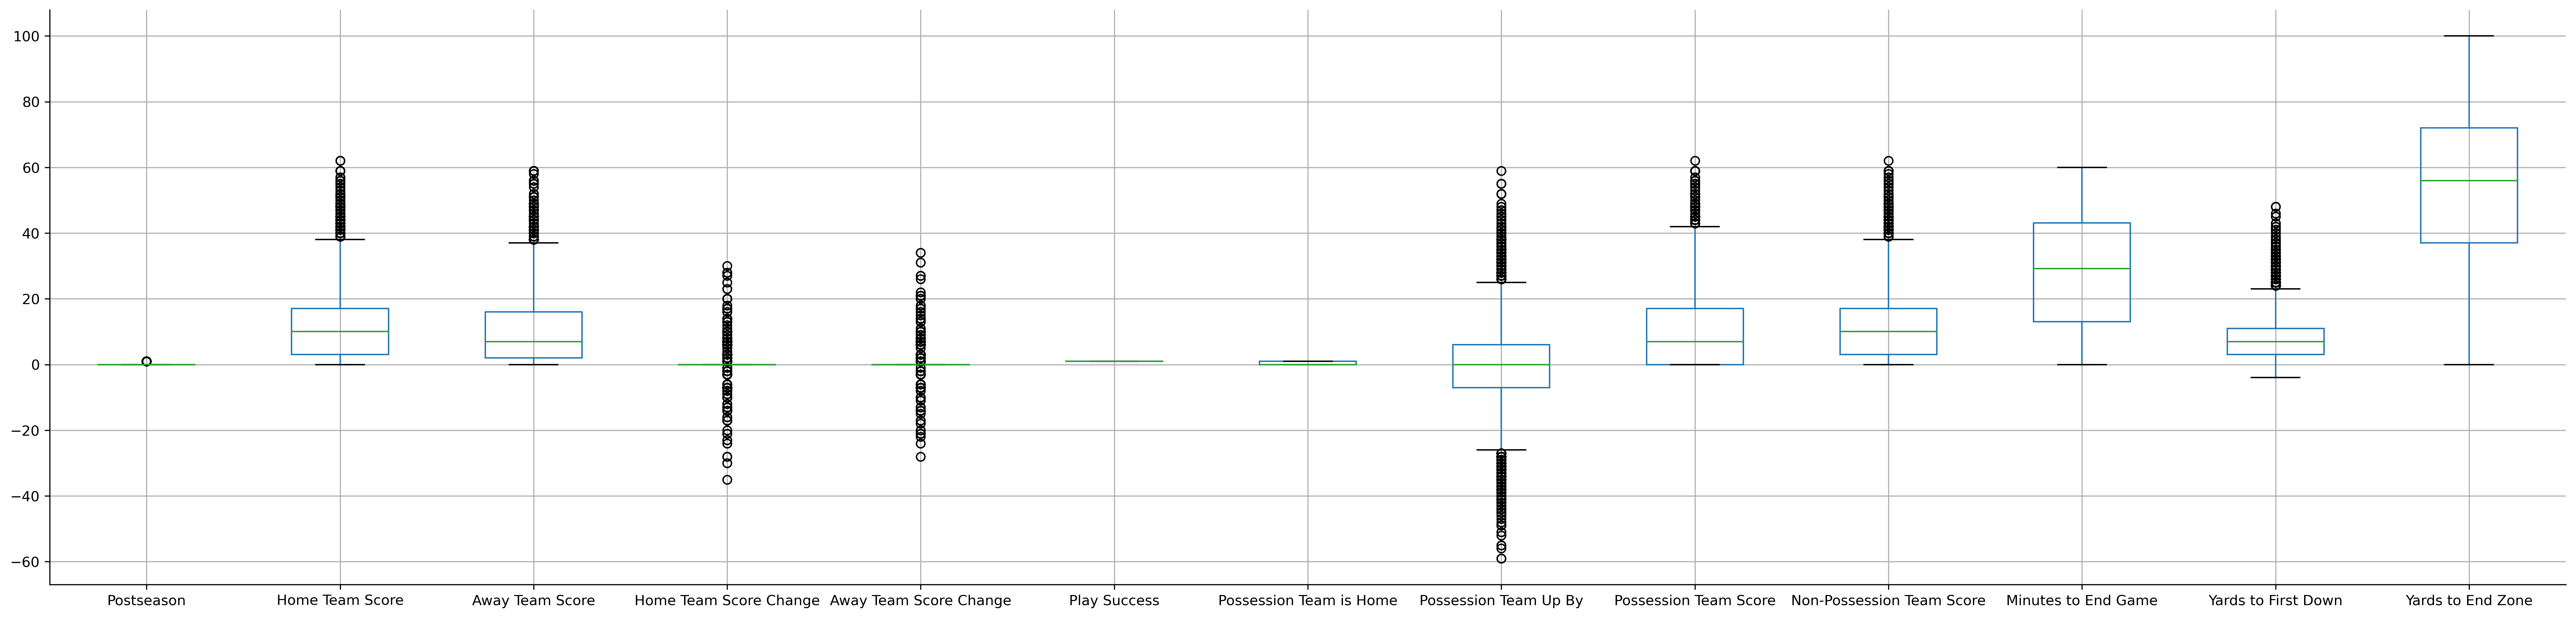

In [23]:
plays.drop(['Game ID'],axis=1).boxplot(figsize=(32,7.5))

In [24]:
# Number of non-sensical records
len(plays[(plays['Home Team Score Change'] < 0) | (plays['Home Team Score Change'] > 8) |
          (plays['Away Team Score Change'] < 0) | (plays['Away Team Score Change'] > 8) |
          (plays['Yards to First Down'] < 0)
         ])

386

In [25]:
plays = plays.drop( plays[(plays['Home Team Score Change'] < 0) | (plays['Home Team Score Change'] > 8) |
                          (plays['Away Team Score Change'] < 0) | (plays['Away Team Score Change'] > 8) |
                          (plays['Yards to First Down'] < 0)
                         ].index )

### Drop Duplicate Data

Rows that are duplicated are dropped from the dataset.

In [26]:
sum(plays.duplicated())  # Number of duplicate rows

18

In [27]:
plays = plays.drop_duplicates()

### Feature Selection

We choose the features that will most likley be useful in choosing 4th-down plays, and discarded the remaining features. The chosen features are all of the ones we calculated, plus "Postseason", which is True when a play is from a postseason game.

- Postseason (bool)
- Possession Team is Home (bool)
- Possession Team Up By (int)
- Possession Team Score (int)
- Non-Possession Team Score (int)
- Minutes to End Game (float)
- Yards to First Down (int)
- Yards to End Zone (int)

Of course, we also keep the Play Type column in our DataFrame, since that is our target.

In [28]:
plays_for_model = plays[['Postseason', 'Possession Team is Home', 'Possession Team Up By',
                         'Possession Team Score', 'Non-Possession Team Score',
                         'Minutes to End Game', 'Yards to First Down', 'Yards to End Zone',
                         'Play Type']]

In [29]:
plays_for_model.head(1)

Postseason  Possession Team is Home  Possession Team Up By  \
0       False                     True                      0   

   Possession Team Score  Non-Possession Team Score  Minutes to End Game  \
0                      0                          0                 56.7   

   Yards to First Down  Yards to End Zone  Play Type  
0                    2                 36  Go For It

The histograms and scatterplots below show the distributions and relationships among the quantiative variables on which the models will be trained.

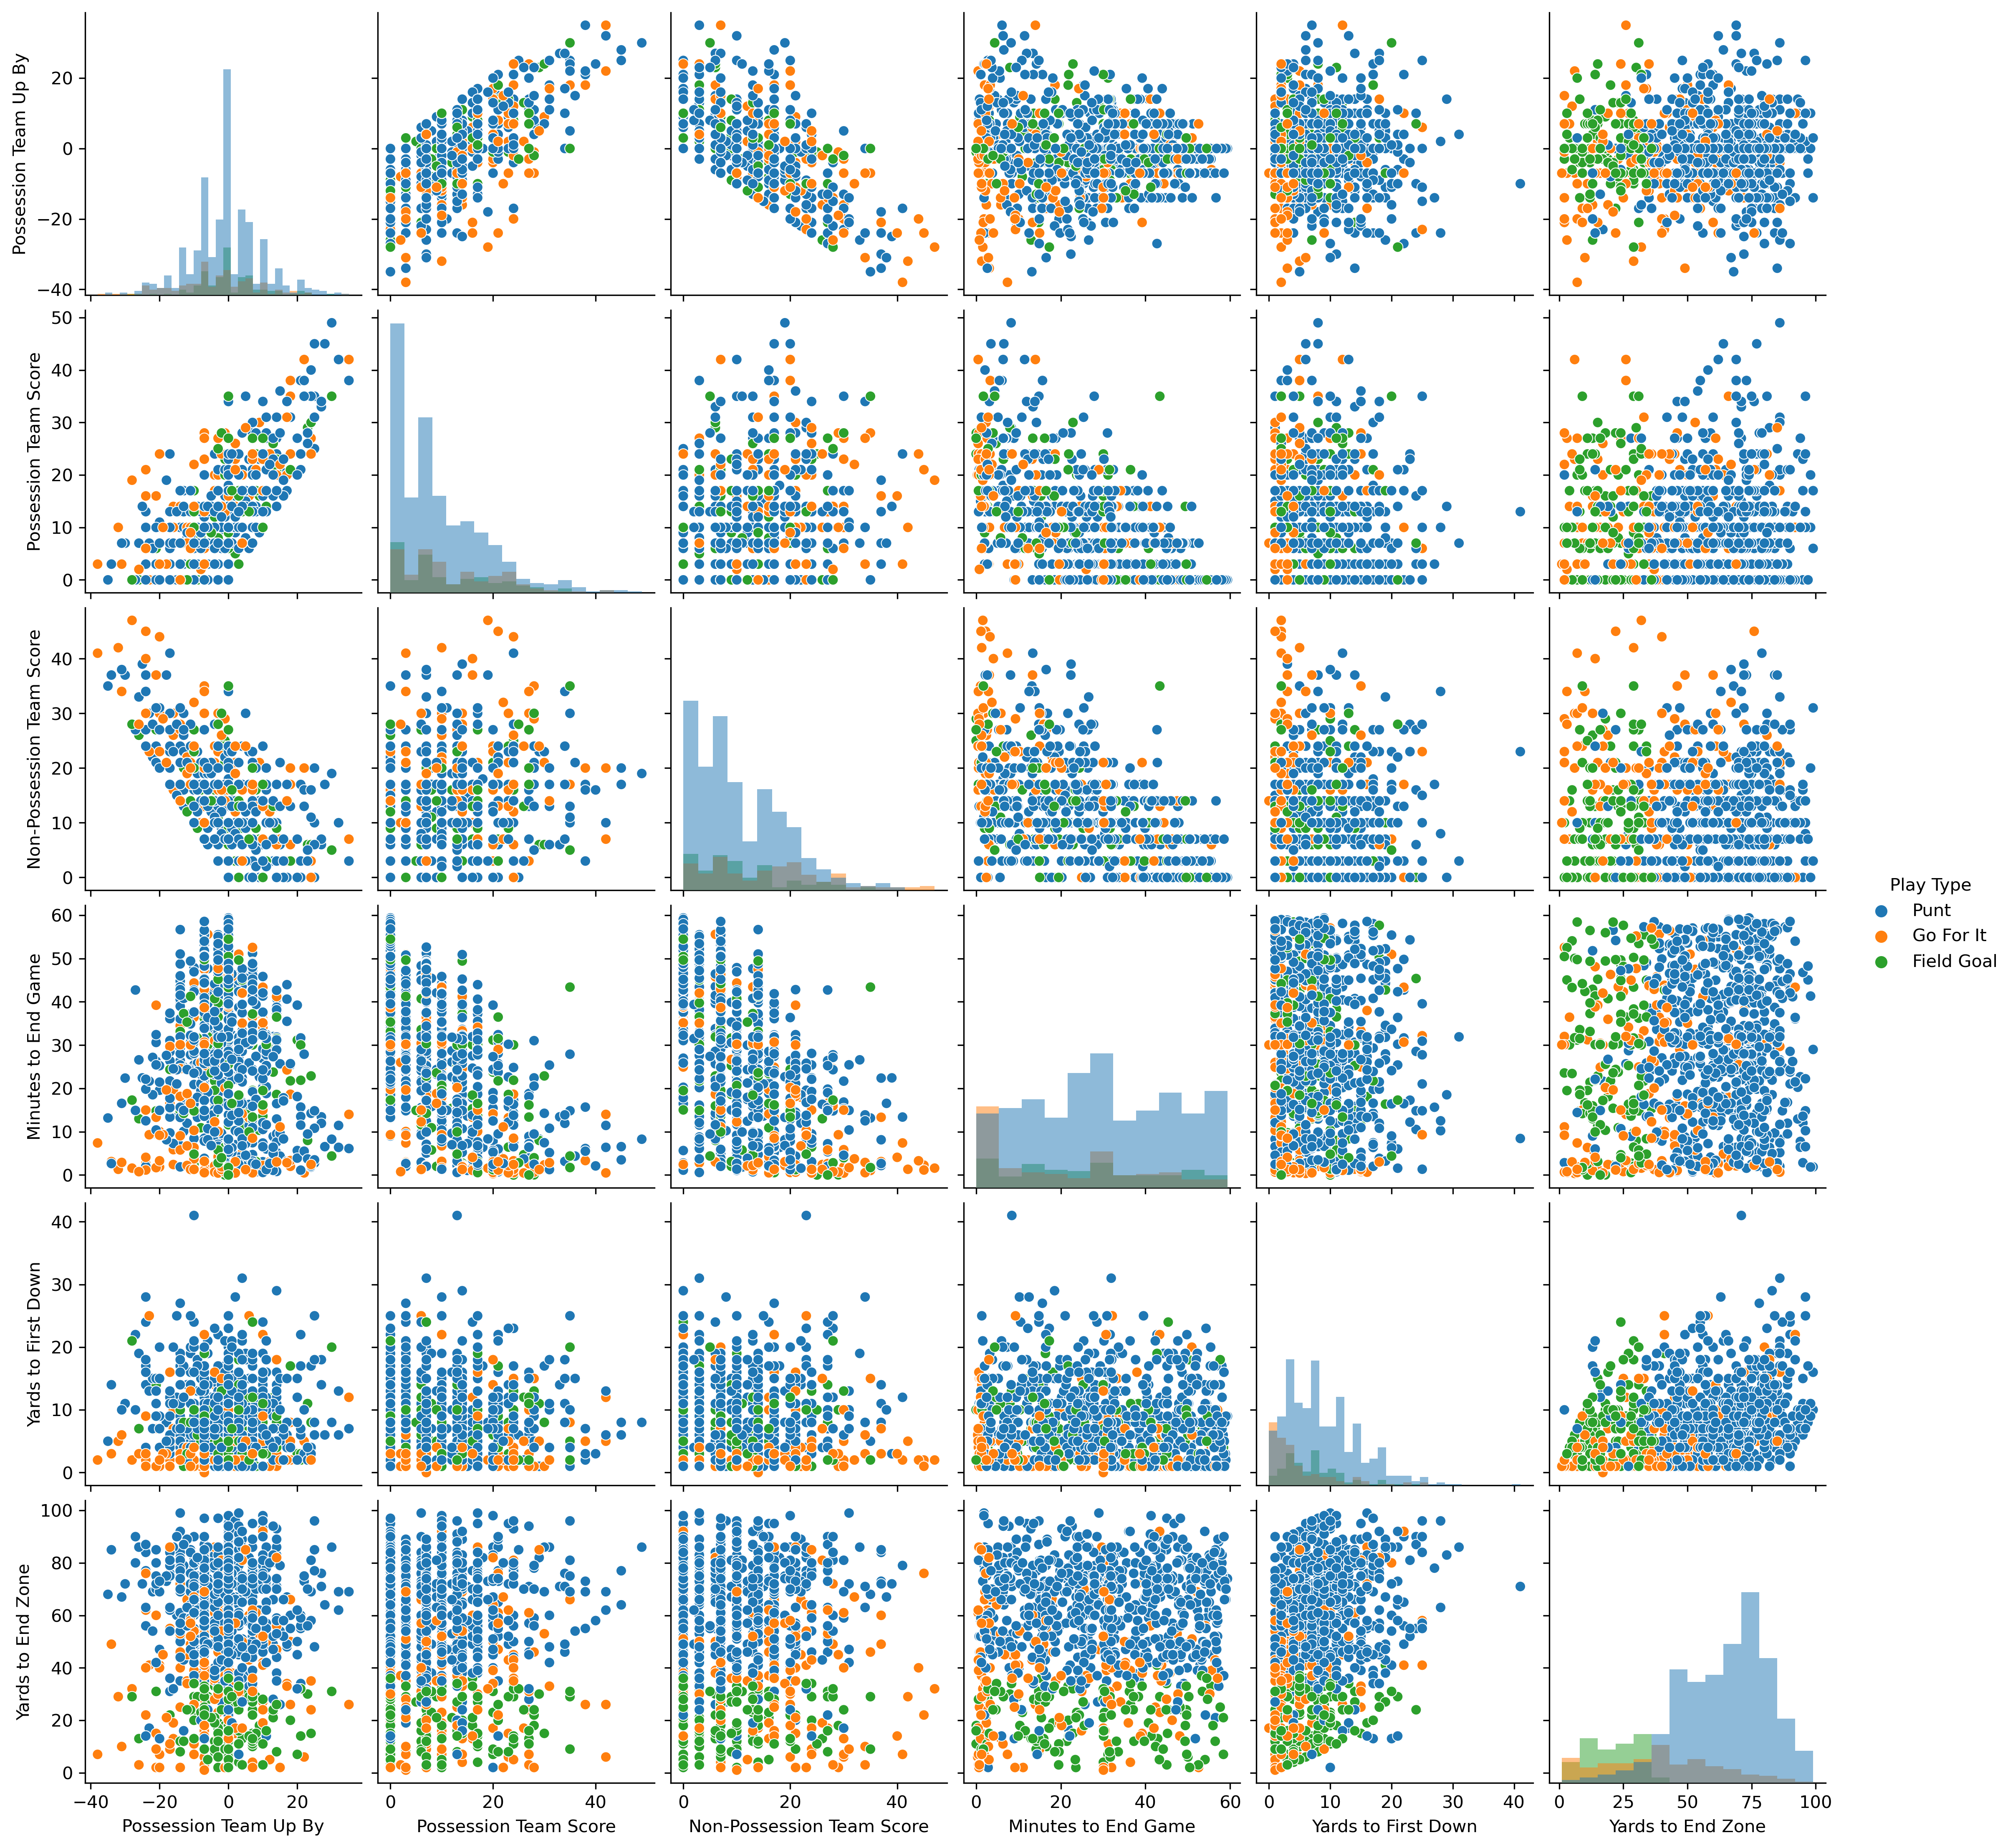

In [30]:
# Plot scatterplots and histograms for each variable (boolean features excluded)
# We only plot a sample of 1000 points as to not overwhelm the graphs
plays_to_plot = plays[list(plays_for_model.select_dtypes(include=['int64', 'float64']).columns) + ['Play Type']].sample(1000)
sns.pairplot(plays_to_plot, hue='Play Type', hue_order=['Punt', 'Go For It', 'Field Goal'], diag_kind='hist', diag_kws=dict(linewidth=0))

## Machine Learning Models

### Data Splitting: Training, Validation, and Testing

We split our dataset into three groups:
- Training (60%, 40960 records)
- Validation (20%, 13653 records)
- Testing (20%, 13654 records)

In [31]:
# produces a 60%, 20%, 20% split for training, validation and test sets.
train, validate, test = np.split(plays_for_model.sample(frac=1), [int(.6*len(plays_for_model)), int(.8*len(plays_for_model))])

We also assign our features to `X` and target to `y` in each of these groups, and print the shape of these NumPy arrays.

In [32]:
feature_cols = ['Postseason', 'Possession Team is Home', 'Possession Team Up By',
                'Possession Team Score', 'Non-Possession Team Score', 'Minutes to End Game',
                'Yards to First Down', 'Yards to End Zone']

In [33]:
train_X = train.loc[:, feature_cols]
train_y = train['Play Type']
validate_X = validate.loc[:, feature_cols]
validate_y_actual = validate.loc[:, 'Play Type']
test_X = test.loc[:, feature_cols]
test_y_actual = test.loc[:, 'Play Type']

In [34]:
print('Training Set')
print(f'X: {train_X.shape}')
print(f'y: {train_y.shape}')
print('Validation Set')
print(f'X: {validate_X.shape}')
print(f'y_actual: {validate_y_actual.shape}')
print('Training Set')
print(f'X: {test_X.shape}')
print(f'y_actual: {test_y_actual.shape}')

Training Set
X: (40960, 8)
y: (40960,)
Validation Set
X: (13653, 8)
y_actual: (13653,)
Training Set
X: (13654, 8)
y_actual: (13654,)


### Model Training

Since we'll be trying several models and using them multiple times, we create a function for each of the models we're going to try. These functions return a fitted model trained on the provided `X` and `y` NumPy arrays

#### Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression

In [36]:
def logistic_regression(X, y):
    logreg = LogisticRegression()
    logreg.fit(X, y)
    return logreg

#### XGBoost

In [37]:
import xgboost as xgb

In [38]:
def xgboost(X, y):
    xgb_cl = xgb.XGBClassifier()
    xgb_cl.fit(X, y)
    return xgb_cl

#### Support Vector Machine

In [39]:
from sklearn.svm import SVC

In [40]:
def support_vector_machine(X, y):
    svc = SVC()
    svc.fit(X, y)
    return svc

#### Gaussian Naive Bayes

In [41]:
from sklearn.naive_bayes import GaussianNB

In [42]:
def naive_bayes(X, y):
    nb = GaussianNB()
    nb.fit(X, y)
    return nb

#### K-Nearest Neighbors Classifier

In [43]:
from sklearn.neighbors import KNeighborsClassifier

In [44]:
def k_nearest_neighbor(X, y):
    knn = KNeighborsClassifier()
    knn.fit(X, y)
    return knn

#### Single Decision Tree

In [45]:
from sklearn.tree import DecisionTreeClassifier

In [46]:
def decision_tree(X, y):
    dt = DecisionTreeClassifier()
    dt.fit(X, y)
    return dt

#### Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
def random_forest(X, y):
    rf = RandomForestClassifier()
    rf.fit(X, y)
    return rf

### Evaulate Each Trained Model

We calculate the accuracy of each of our trained models on the the validation set, in order to get an idea of which model is performing the best.

In [49]:
def evaluate_model(model, X, y_actual):
    y_predicted = model.predict(X)
    results = pd.DataFrame()
    results['Predicted by Model'] = y_predicted
    results['Actual'] = list(y_actual)
    results['Model Matches Actual'] = (results['Predicted by Model'] == results['Actual'])
    accuracy = sum(results['Model Matches Actual']) / len(results)
    return accuracy, y_predicted

In [50]:
models = [naive_bayes, decision_tree, logistic_regression, k_nearest_neighbor,
          support_vector_machine, random_forest, xgboost]

In [ ]:
accuracies = {}
for model in models:
    fitted_model = model(train_X, train_y)
    accuracy, _ = evaluate_model(fitted_model, validate_X, validate_y_actual)
    accuracies[model.__name__] = accuracy

The following dictionary and horizontal bar plot shows the accuracy of each trained model on the validation dataset, as a percentage. XGBoost performed the best, reaching an accuracy of approximately 87% on the validation data.

In [52]:
accuracies

{'naive_bayes': 0.7898630337654728,
 'decision_tree': 0.7950633560389658,
 'logistic_regression': 0.8133011059840328,
 'k_nearest_neighbor': 0.8316120999047828,
 'support_vector_machine': 0.8359334944700798,
 'random_forest': 0.8525598769501208,
 'xgboost': 0.8674284040137699}

<BarContainer object of 7 artists>

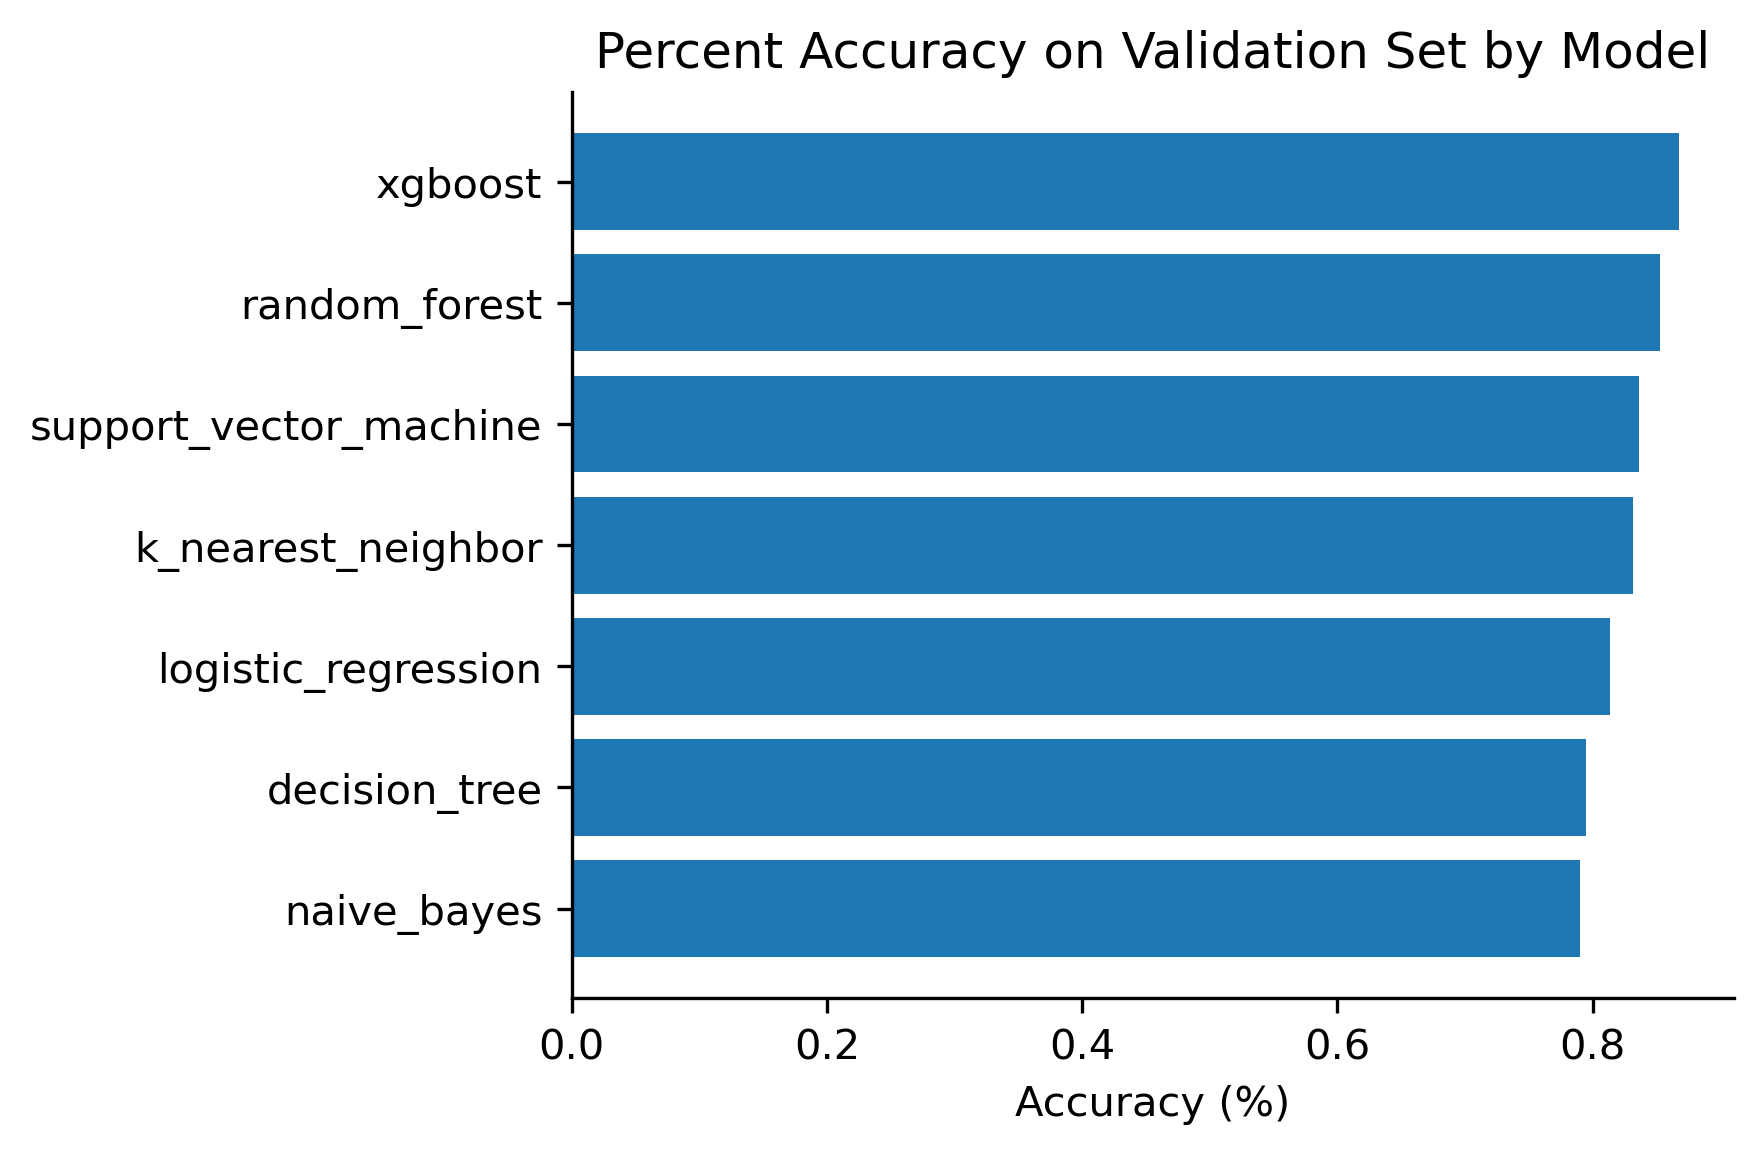

In [53]:
plt.figure(figsize=(5,4))
plt.title('Percent Accuracy on Validation Set by Model')
plt.xlabel('Accuracy (%)')
plt.barh(*zip(*accuracies.items()))

## Hyperparameter Tuning

Having identified our XGBoost model as being the best performer, we want to tune the model's hyperparameters to see if we can improve the model's accuracy further.

To start we create a function `xgboost_params`, which takes an `X` and `y` for training the model, plus several hyperparameters that can be adjusted.

In [54]:
def xgboost_params(X, y, n_estimators=100, max_depth=6, colsample_bytree=1, subsample=1, num_parallel_tree=1, learning_rate=0.3):
    xgb_cl = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        colsample_bytree=colsample_bytree,
        subsample=subsample,
        num_parallel_tree=num_parallel_tree,
        learning_rate=learning_rate)
    xgb_cl.fit(X, y)
    return xgb_cl

The function `tuning_plot` plots a line chart with the accuracy of the model at different parameter values. A star is plotted at the maximum accuracy plotted in the graph, and the value of the parameter at this maximum accuracy is the ideal value for said parameter.

In [55]:
def tuning_plot(parameter_name, parameter_values, parameter_acc):
    plt.plot(parameter_values, parameter_acc)
    plt.xlabel(parameter_name)
    plt.ylabel("Accuracy (%)")
    plt.plot(parameter_values[list(parameter_acc).index(max(parameter_acc))],
             max(parameter_acc), 'k*', markersize=15)

#### n_estimators

`n_estimators` specifies the number of decision trees allowed in our ensemble of decision trees. When we ran this analysis, we found 30 was the optimal value, but this may vary due to the stochastic nature of model fitting.

In [ ]:
n_estimators = [1, 5, 10, 15, 20, 25, 30, 35, 40, 50, 75, 100]
n_estimators_acc = []
for n in n_estimators:
    tuned_model = xgboost_params(train_X, train_y, n_estimators=n)
    accuracy, _ = evaluate_model(tuned_model, validate_X, validate_y_actual)
    n_estimators_acc.append(accuracy)
n_estimators_acc = np.array(n_estimators_acc)*100

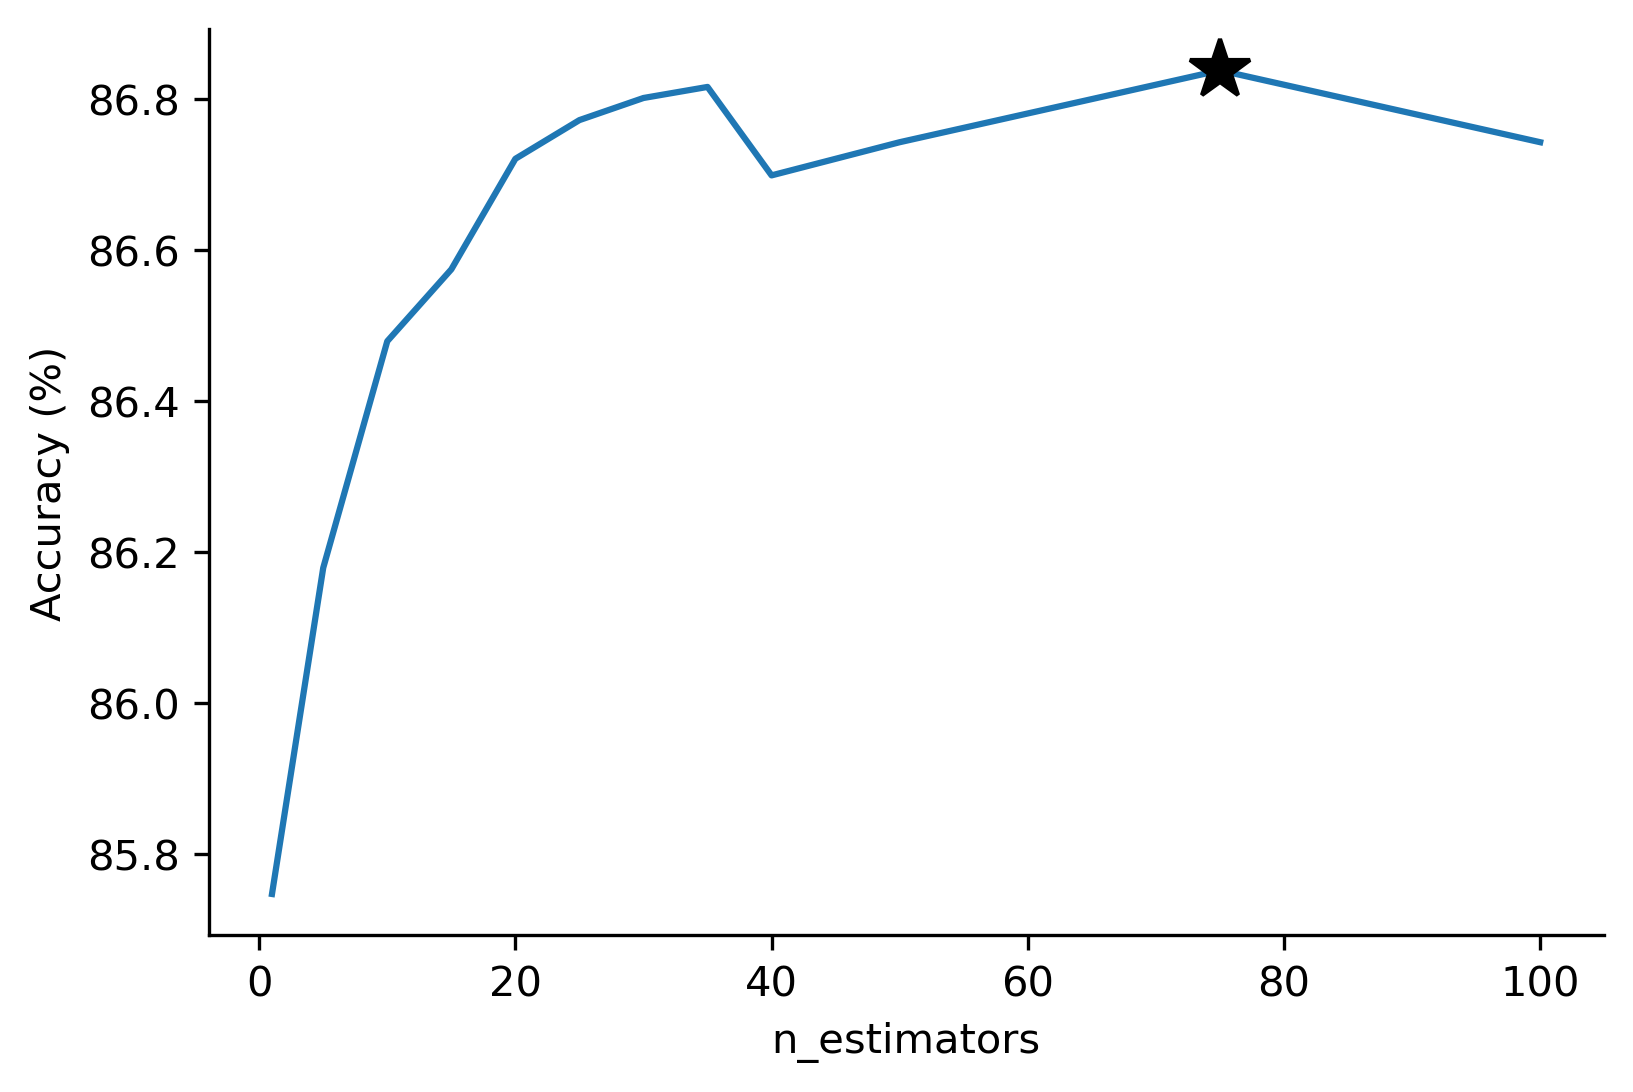

In [57]:
tuning_plot('n_estimators', n_estimators, n_estimators_acc)

#### max_depth

`max_depth` specifies the maximum depth a tree can have. When we ran this analysis, we found that 6 was the optimal value, but this may vary due to the stochastic nature of model fitting.

In [ ]:
max_depth = list(range(20))
max_depth_acc = []
for i in max_depth:
    tuned_model = xgboost_params(train_X, train_y, n_estimators=30, max_depth=i)
    accuracy, _ = evaluate_model(tuned_model, validate_X, validate_y_actual)
    max_depth_acc.append(accuracy)
max_depth_acc = np.array(max_depth_acc)*100

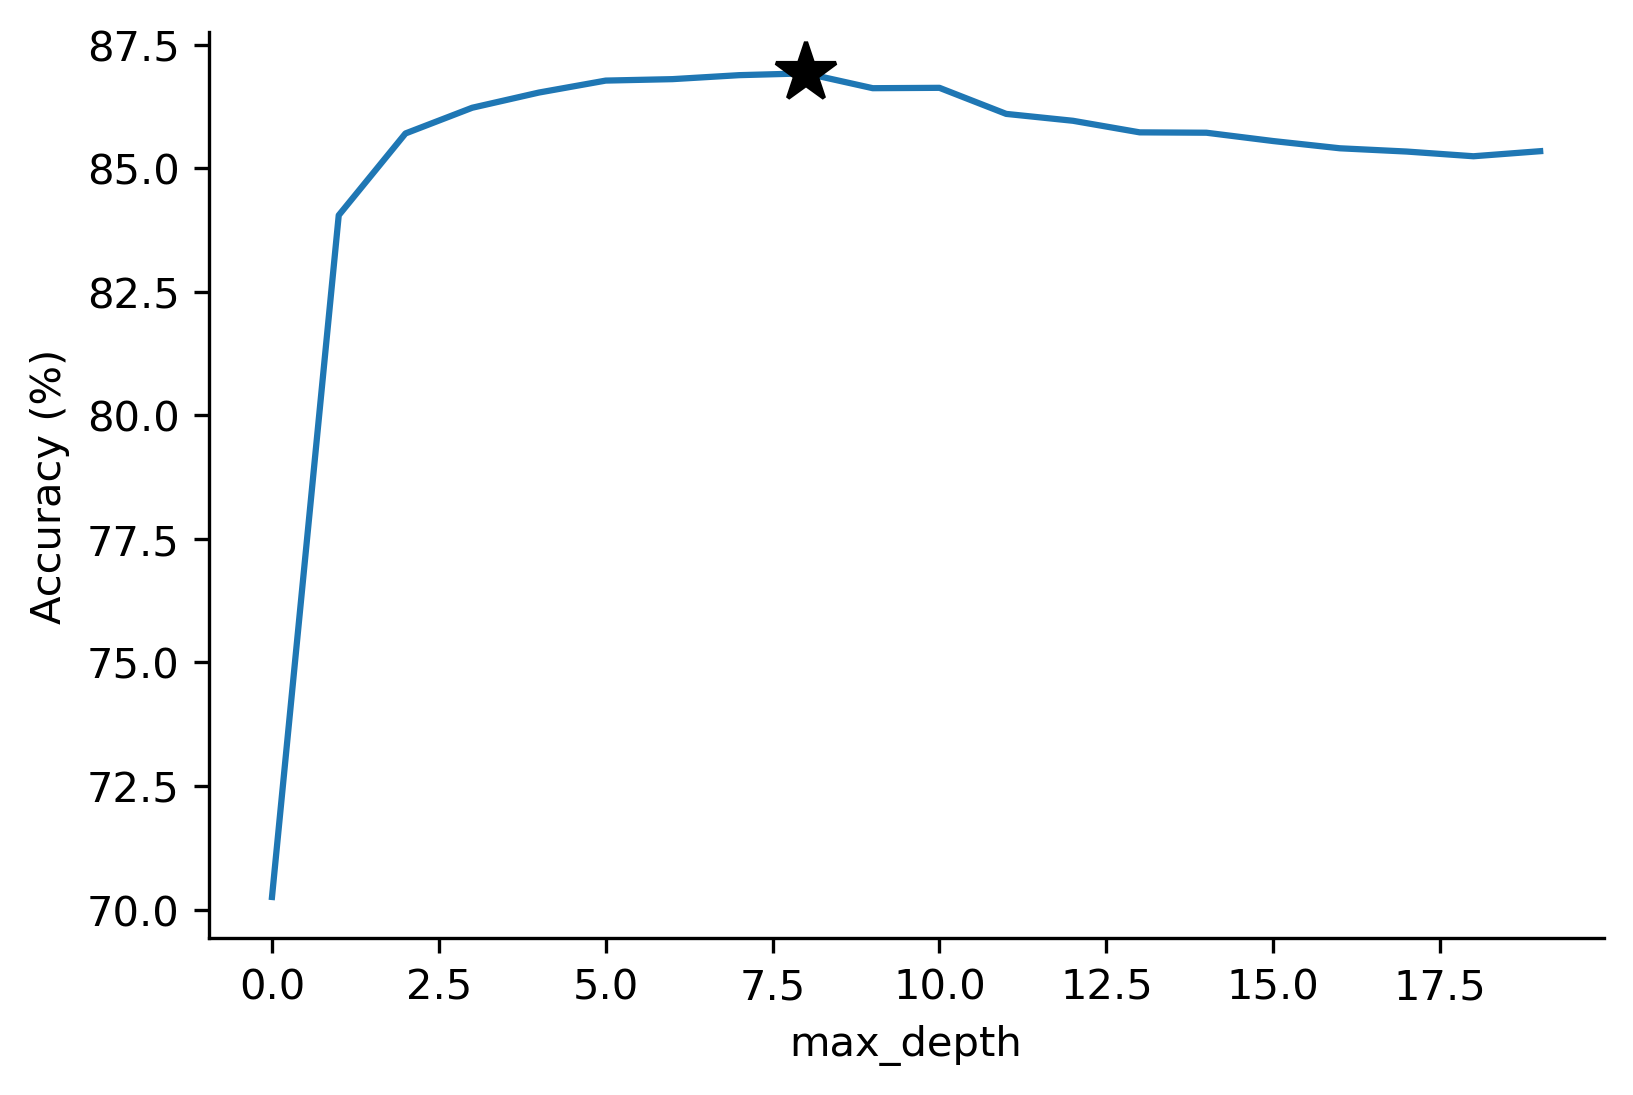

In [59]:
tuning_plot('max_depth', max_depth, max_depth_acc)

#### colsample_bytree

`colsample_bytree` specifies the percentage of features randomly selected for use in building trees. When we ran this analysis, we found that 0.8 (80%) was the optimal value, but this may vary due to the stochastic nature of model fitting.

In [ ]:
colsample_bytree = np.linspace(0.1, 1, 10)
colsample_bytree_acc = []
for i in colsample_bytree:
    tuned_model = xgboost_params(train_X, train_y, n_estimators=30, max_depth=6, colsample_bytree=i)
    accuracy, _ = evaluate_model(tuned_model, validate_X, validate_y_actual)
    colsample_bytree_acc.append(accuracy)
colsample_bytree_acc = np.array(colsample_bytree_acc)*100

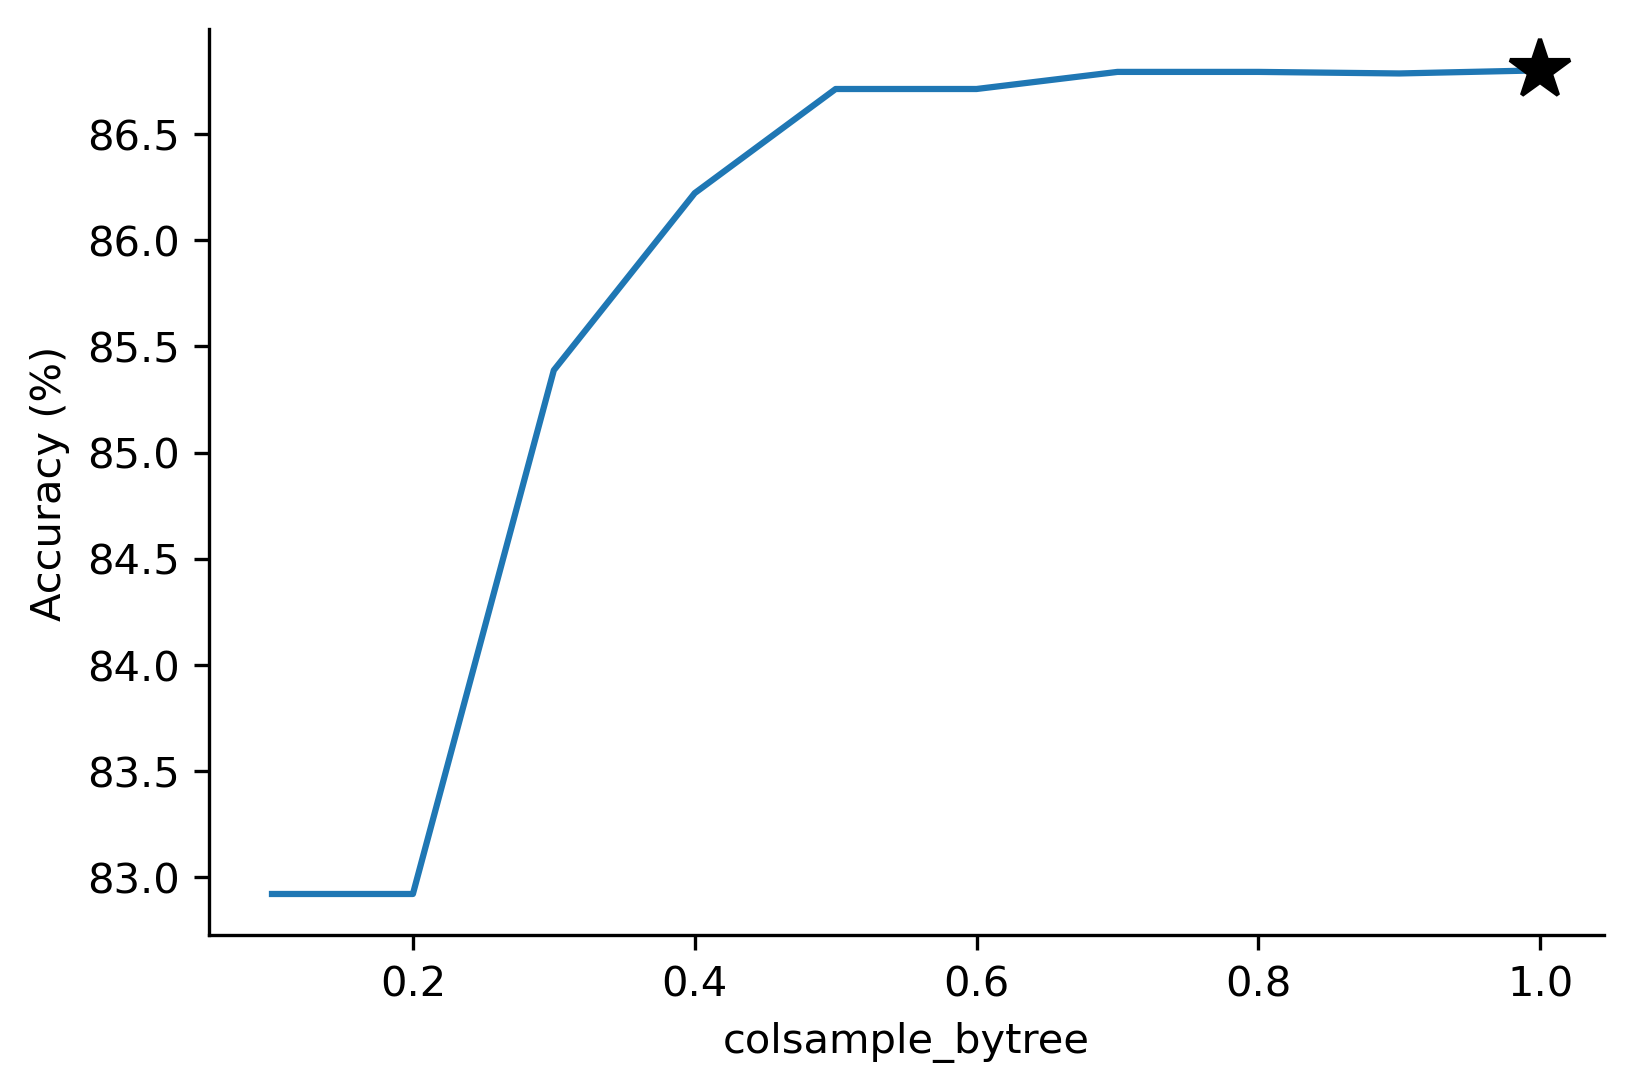

In [61]:
tuning_plot('colsample_bytree', colsample_bytree, colsample_bytree_acc)

#### subsample

`subsample` specifies the percentage of samples to random choose for use in tree building. When we ran this analysis, we found that 0.7 (70%) was the optimal value, but this may vary due to the stochastic nature of model fitting.

In [ ]:
subsample = np.linspace(0.1, 1, 10)
subsample_acc = []
for i in subsample:
    tuned_model = xgboost_params(train_X, train_y, n_estimators=30, max_depth=6, colsample_bytree=0.8, subsample=i)
    accuracy, _ = evaluate_model(tuned_model, validate_X, validate_y_actual)
    subsample_acc.append(accuracy)
subsample_acc = np.array(subsample_acc)*100

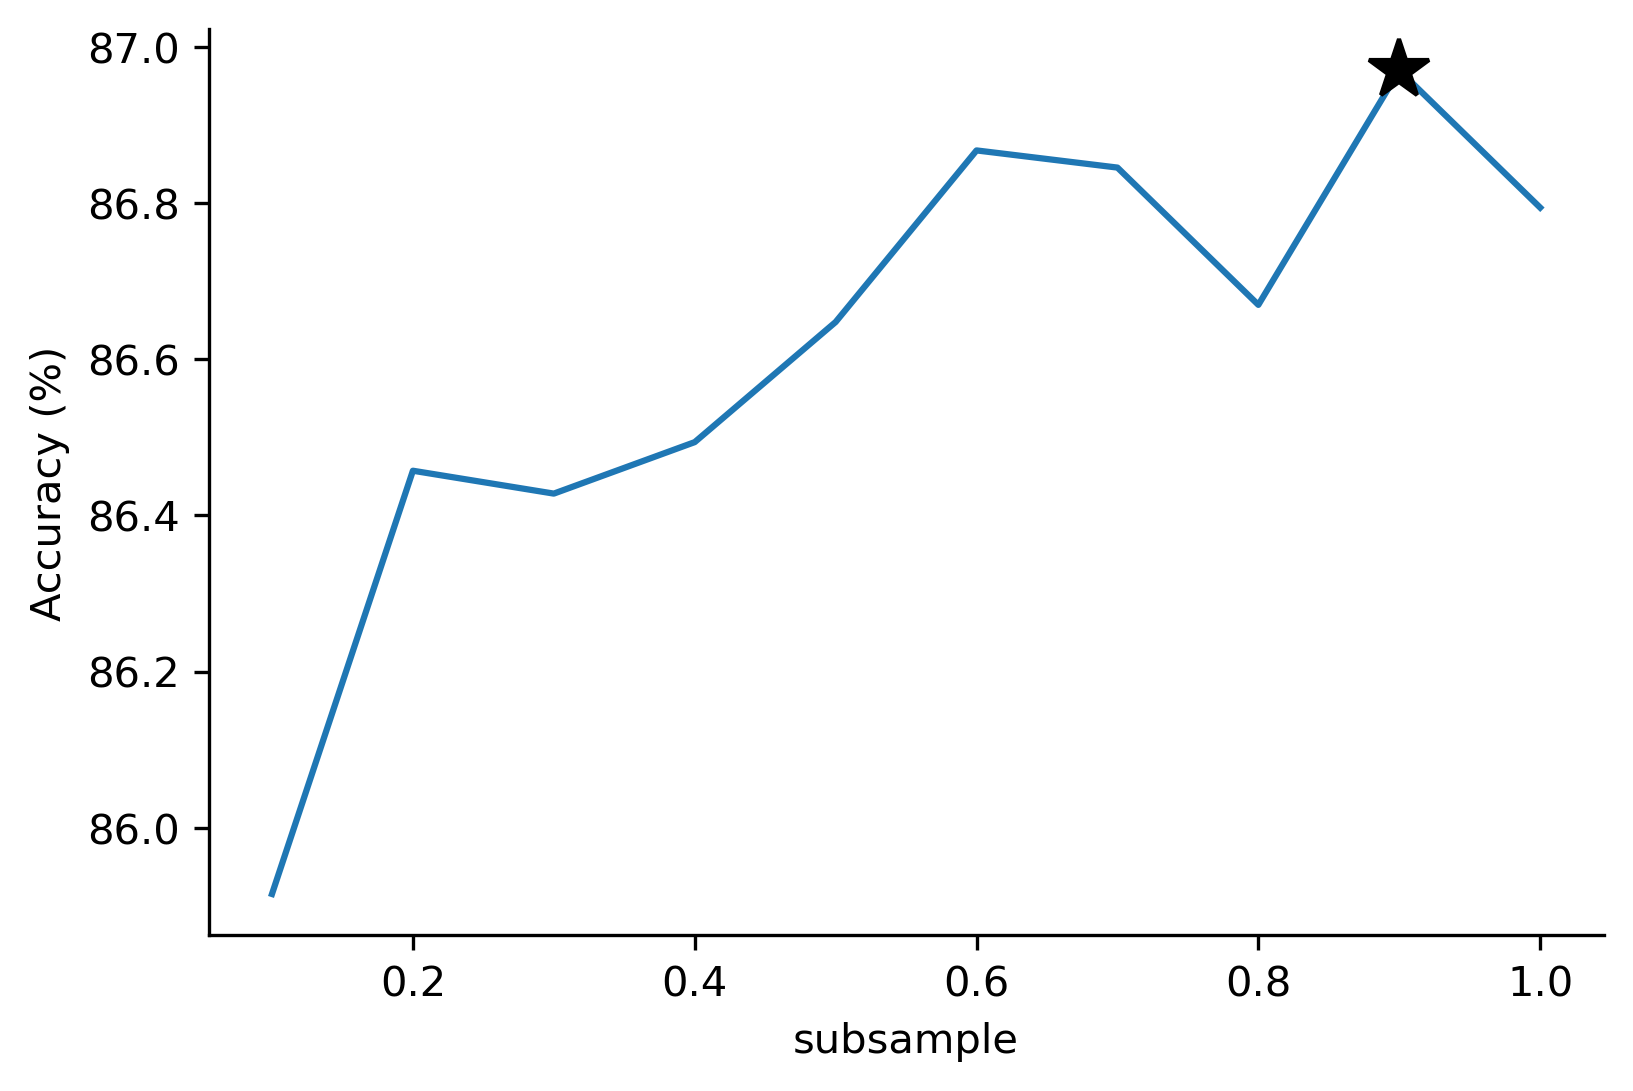

In [63]:
tuning_plot('subsample', subsample, subsample_acc)

#### num_parallel_tree

`num_parallel_tree` specifies the number of trees to create in parallel on each training iteration, which is part of the boosting process. When we ran this analysis, we found that 1 was the optimal value, but this may vary due to the stochastic nature of model fitting.

In [ ]:
num_parallel_tree = list(range(1, 11))
num_parallel_tree_acc = []
for i in num_parallel_tree:
    tuned_model = xgboost_params(train_X, train_y, n_estimators=30, max_depth=6, colsample_bytree=0.8, subsample=0.7, num_parallel_tree=i)
    accuracy, _ = evaluate_model(tuned_model, validate_X, validate_y_actual)
    num_parallel_tree_acc.append(accuracy)
num_parallel_tree_acc = np.array(num_parallel_tree_acc)*100

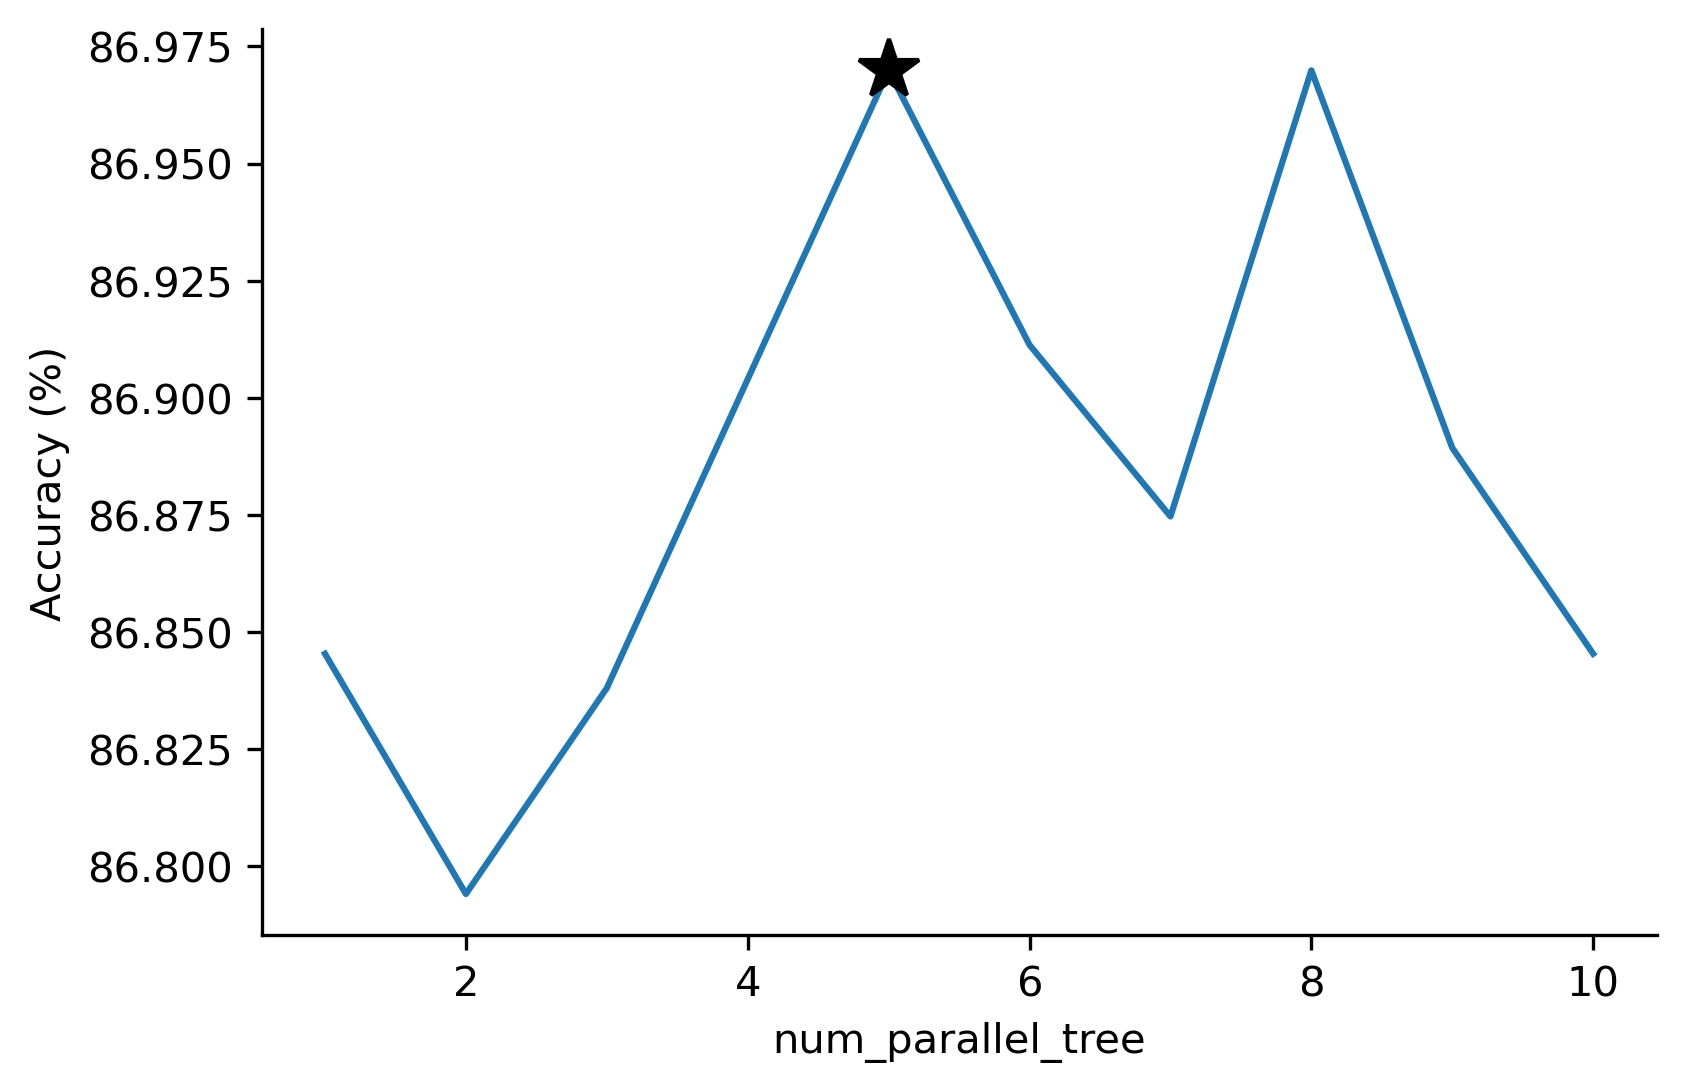

In [65]:
tuning_plot('num_parallel_tree', num_parallel_tree, num_parallel_tree_acc)

#### learning_rate

`learning_rate` specifies the rate of model improvement over training iterations. When we ran this analysis, we found that 0.3 was the optimal value, but this may vary due to the stochastic nature of model fitting.

In [ ]:
learning_rate = np.linspace(0.1, 1, 10)
learning_rate_acc = []
for i in learning_rate:
    tuned_model = xgboost_params(train_X, train_y, n_estimators=30, max_depth=6, colsample_bytree=0.8, subsample=0.7, num_parallel_tree=1, learning_rate=i)
    accuracy, _ = evaluate_model(tuned_model, validate_X, validate_y_actual)
    learning_rate_acc.append(accuracy)
learning_rate_acc = np.array(learning_rate_acc)*100

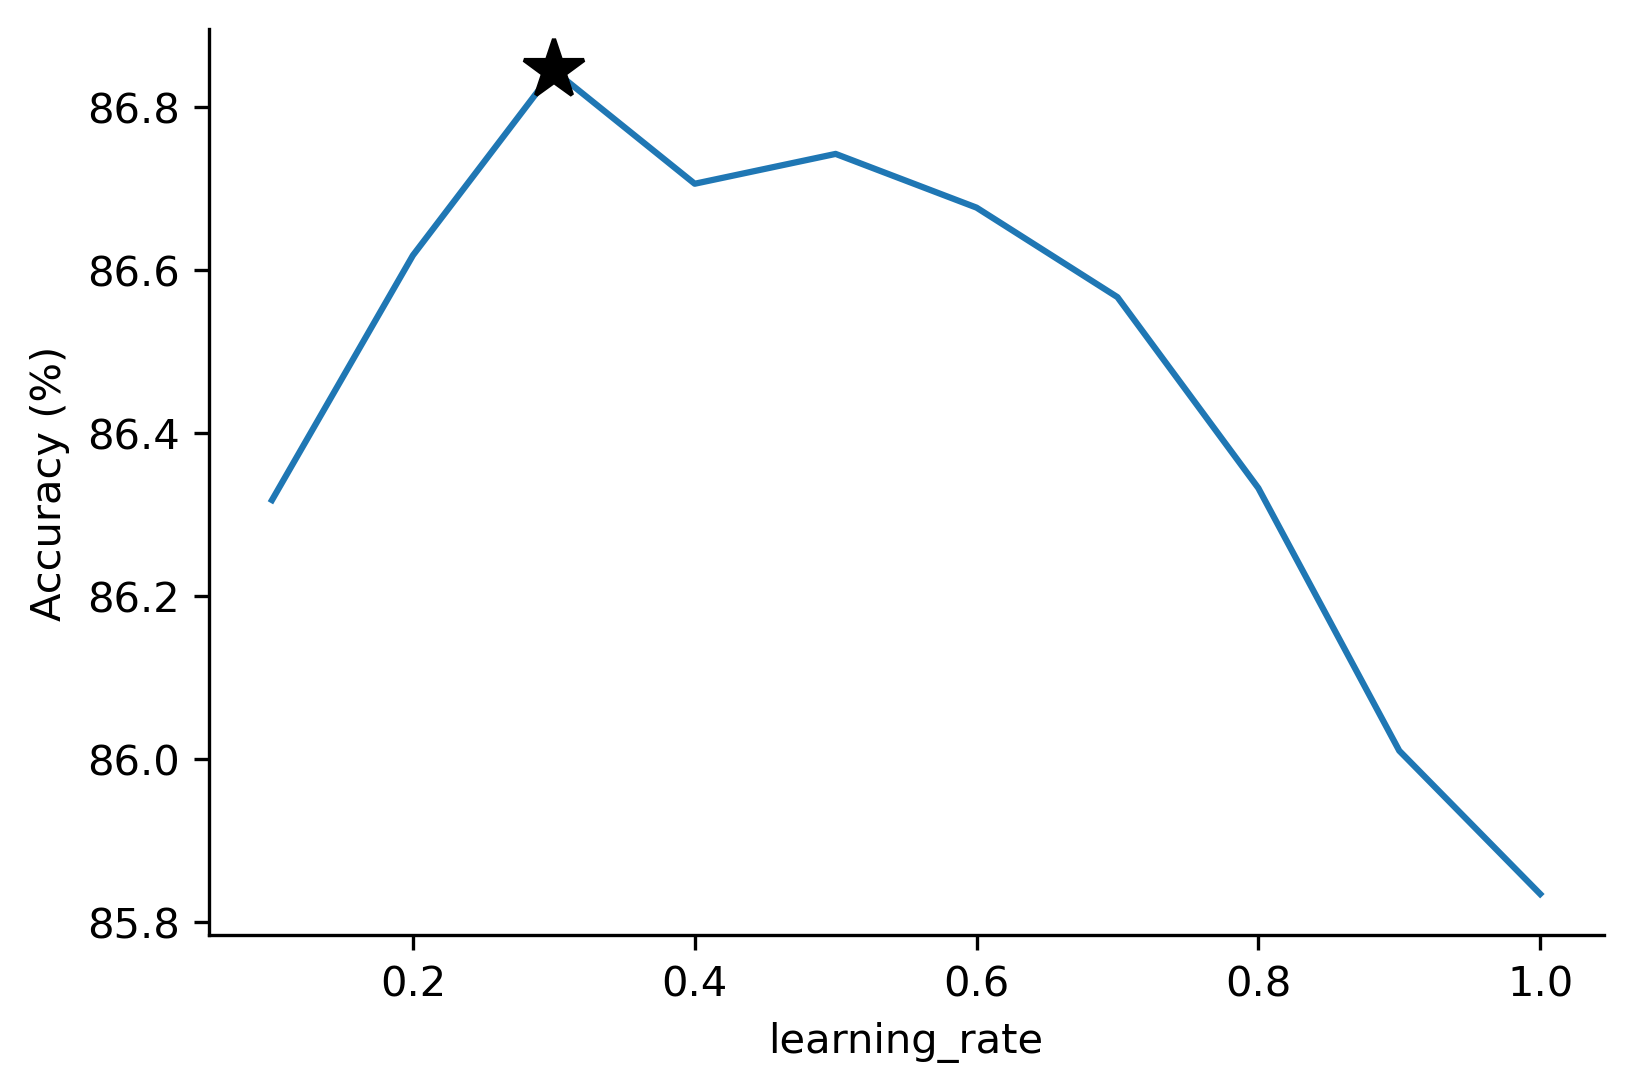

In [67]:
tuning_plot('learning_rate', learning_rate, learning_rate_acc)

## Final Model

Using the our tuned parameters, we train our finalized model, and then calculate the accuracy of our final model.

In [ ]:
final_model = xgboost_params(train_X,
                             train_y,
                             n_estimators=30,
                             max_depth=6,
                             colsample_bytree=0.8,
                             subsample=0.7,
                             num_parallel_tree=1,
                             learning_rate=0.3)

In [69]:
evaluate_model(final_model, test_X, test_y_actual)[0]

0.8670719203163908

The following confusion matrix shows the accuracy of our model on each of the classes, and the classes in which errors occured more or less frequently.

In [70]:
from sklearn.metrics import confusion_matrix, classification_report

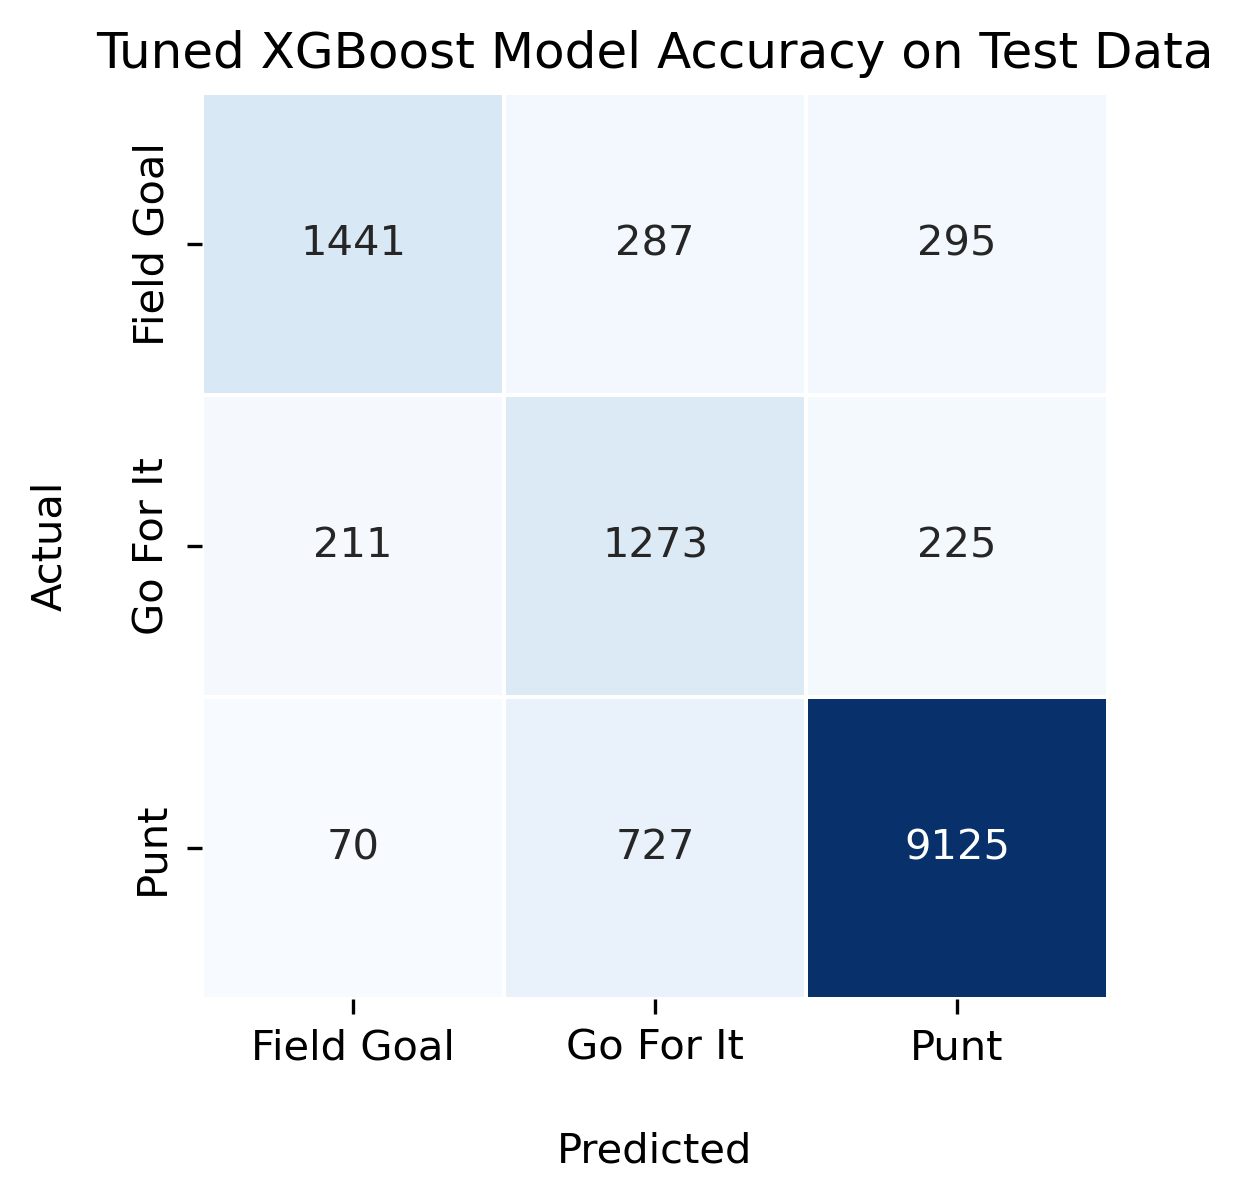

In [71]:
cf_matrix = confusion_matrix(
    evaluate_model(final_model, test_X, test_y_actual)[1],
    np.array(test_y_actual))
ax = sns.heatmap(cf_matrix, annot=True, fmt="d", linewidths=0.5, cmap='Blues', cbar=False,
                 xticklabels=final_model.classes_, yticklabels=final_model.classes_, square=True).set(
                 title='Tuned XGBoost Model Accuracy on Test Data',
                 xlabel='\nPredicted', ylabel='Actual\n')

The classification report shows the precision and recall for each of our three classes.

In [72]:
print(classification_report(
    evaluate_model(final_model, test_X, test_y_actual)[1],
    np.array(test_y_actual),
    digits=3))

              precision    recall  f1-score   support

  Field Goal      0.837     0.712     0.770      2023
   Go For It      0.557     0.745     0.637      1709
        Punt      0.946     0.920     0.933      9922

    accuracy                          0.867     13654
   macro avg      0.780     0.792     0.780     13654
weighted avg      0.881     0.867     0.872     13654



Finally, the graph below shows the importance of our different input variables.

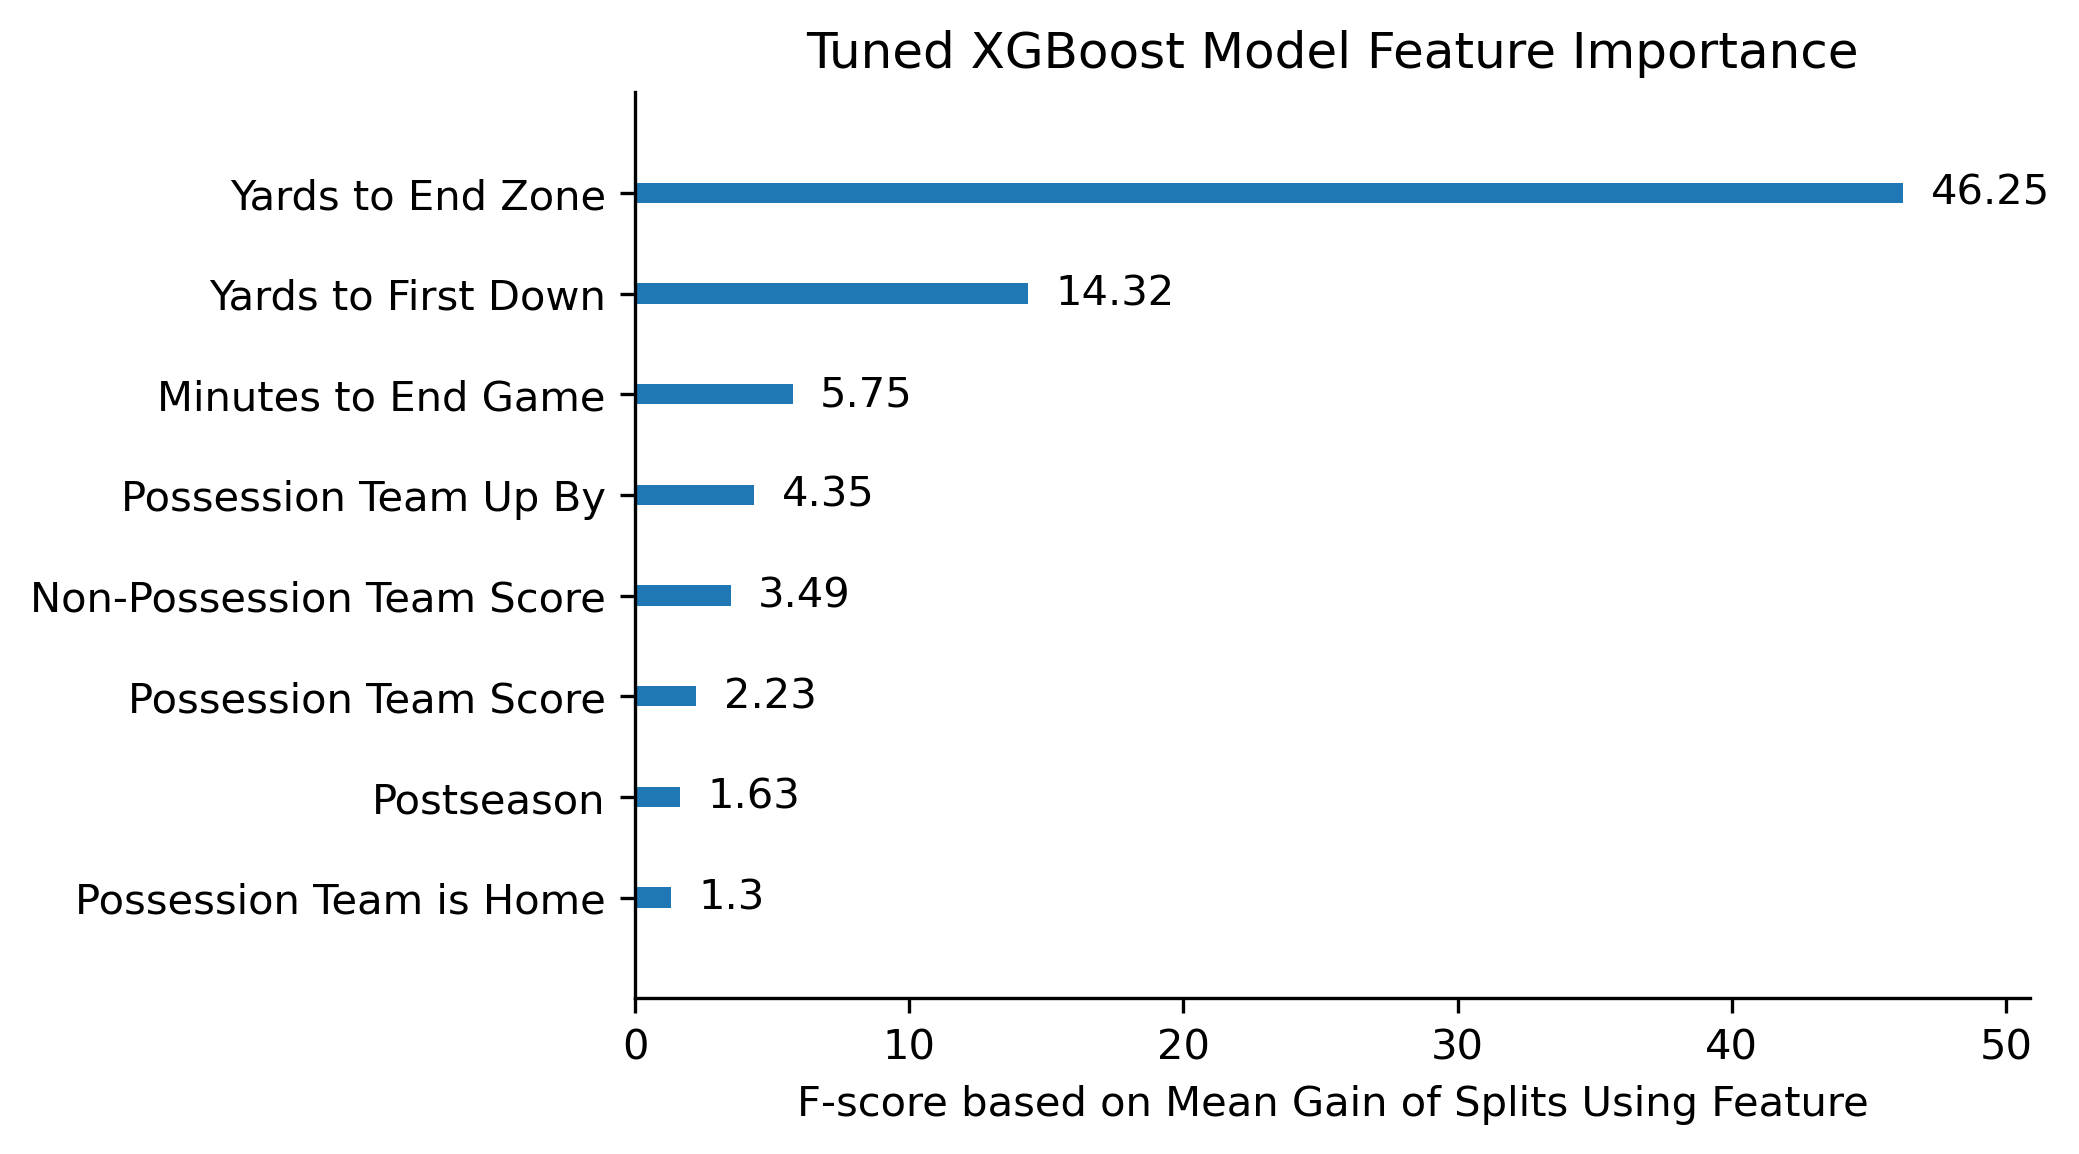

In [75]:
booster = final_model.get_booster()
importance = booster.get_score(importance_type="gain")
importance = {key : round(importance[key], 2) for key in importance}
ax = xgb.plot_importance(importance,
                    grid=False,
                    importance_type='gain').set(xlabel='F-score based on Mean Gain of Splits Using Feature', ylabel='', title='Tuned XGBoost Model Feature Importance')

Thanks for taking a look at our work, we hope you enjoyed it!